### 20200422: Downstream analyses of 3D genomic changes in _L. pneumophila_ infected _A. castellanii_
**cmdoret**

In this notebook, I investigate the gene annotations located close to 3D changes during infection of amoeba by _Legionella pneumophila_. To summarise the context, this is a follow-up on 2 analyses:

1. Genome assembly and annotation of _A. castellanii_ using ONT long reads, Hi-C, Illumina shotgun and RNAseq
2. Pattern detection in Hi-C maps from _A. castellanii_ and quantification of their change during infection.

I use the annotations generated in 1. to investigate potential roles of affected regions in 2.

In [109]:
# Load files and packages
from typing import List, Union, Iterable, Optional
import numpy as np
import pandas as pd
import os
import warnings
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import hicstuff.hicstuff as hcs
import hicstuff.view as hcv
import cooler
import pareidolia.io as pai
import pareidolia.hic_utils as pah
import pareidolia.stats as pas
from cooltools.sample import sample_cooler

os.chdir("/home/cmatthey/Repos/Acastellanii_legionella_infection/")
out = 'data/output/'
indir = 'data/input/'
res = 2000
samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
#infected_bedgraph = pd.read_csv(out + 'all_signals_AT420.bedgraph', sep='\t')
#healthy_bedgraph = pd.read_csv(out + 'all_signals_AT421.bedgraph', sep='\t')
borders_change = pd.read_csv(out + 'pareidolia/borders_change_infection_time.tsv', sep='\t')
loops_change = pd.read_csv(out + 'pareidolia/loops_change_infection_time.tsv', sep='\t')
genes = pd.read_csv(indir + 'annotations/c3_annotations/Acanthamoeba_castellanii_C3.annotations.txt', sep='\t')
genes = genes.rename(columns={"Contig": "Chromosome", "Stop": "End"}).groupby("GeneID").head(1)
# Remove genes which do not have an entrez id
#genes = genes.loc[~np.isnan(genes.entrezgene_id), :]
#genes.entrezgene_id = genes.entrezgene_id.astype(int)


In [2]:
genes.head()

,GeneID,TranscriptID,Feature,Chromosome,Start,End,Strand,Name,Product,Alias/Synonyms,...,GO Terms,Secreted,Membrane,Protease,CAZyme,Notes,gDNA,mRNA,CDS-transcript,Translation
0,VMHBD_00001,VMHBD_00001-T1,mRNA,scaffold_1,504,5457,-,NaN,hypothetical protein,NaN,...,GO_component: GO:0016020 - membrane [Evidence ...,NaN,NaN,NaN,NaN,NaN,ATGGCCACGAAAGATTTCAAGATCGCCAGTACGCGTGCCTCCTTTT...,TTACTTGGCAAGTGGGACAAAGAGAAATCCCTTTTGGCATTGTGCA...,TTACTTGGCAAGTGGGACAAAGAGAAATCCCTTTTGGCATTGTGCA...,MATKDFKIAIGGPGGVGKSAIVLQFVTGNYVSEYDPTIEDAYRKQF...
1,VMHBD_00002,VMHBD_00002-T1,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
2,VMHBD_00002,VMHBD_00002-T2,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
3,VMHBD_00002,VMHBD_00002-T3,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
4,VMHBD_00002,VMHBD_00002-T4,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...


In [3]:
# Manage cools, merge samples by condition to increase coverage in visualisations
def gather_and_merge_cools(condition: str, merged_out: str):
    cools = (
        samples.loc[samples.condition == condition, 'library']
        .apply(lambda p: f"{out}/cool/{p}.mcool::/resolutions/{res}")
        .tolist()
    )
    cooler.merge_coolers(merged_out, cools, mergebuf=10e8)
    
gather_and_merge_cools('uninfected', "healthy.cool")
gather_and_merge_cools('infected', "infected.cool")


INFO :: Merging:
data/output//cool/AT419.mcool::/resolutions/2000
data/output//cool/AT421.mcool::/resolutions/2000
INFO :: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO :: NumExpr defaulting to 8 threads.
INFO :: Creating cooler at "healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [543334, 1122973]
INFO :: current: [543334, 1122973]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Merging:
data/output//cool/AT418.mcool::/resolutions/2000
data/output//cool/AT420.mcool::/resolutions/2000
INFO :: Creating cooler at "infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [2188239, 1287104]
INFO :: current: [2188239, 1287104]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done


In [4]:

# Subsample cools to identical coverage between conditions
def subsample_cools(cools: List[str], cpus: int=8, balance: bool=True) -> List['cooler.Cooler']:
    if cpus > 1:
        import multiprocessing as mp
        pool = mp.Pool(cpus)
        my_map = pool.imap_unordered
    else:
        my_map = map
    coolers = pai.get_coolers(cools)
    target = pah.get_min_contacts(coolers)
    sub_cools = ["sub_" + cl for cl in cools]
    for i in range(len(cools)):
        sample_cooler(
            coolers[i],
            sub_cools[i],
            count=target-1,
            exact=False,
            map_func=my_map
        )
    sub_coolers = pai.get_coolers(sub_cools)
    # Balance the subsampled versions
    if balance:
        for clr in sub_coolers:
            cooler.balance_cooler(
                clr,store=True,
                map=my_map,
                mad_max=5,
                chunksize=10000000,
                min_nnz=10,
                max_iters=200,
                ignore_diags=2
            )
    if cpus > 1:
        pool.close()
    return sub_coolers

healthy_cool, infected_cool = subsample_cools(['healthy.cool', 'infected.cool'])

INFO :: Creating cooler at "sub_healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Creating cooler at "sub_infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: variance is 16321.89888928304
INFO :: variance is 4752.978898612537
INFO :: variance is 1027.5860770375184
INFO :: variance is 779.7869935102085
INFO :: variance is 233.84633329184598
INFO :: variance is 168.20475619948007
INFO :: variance is 60.64554772540176
INFO :: variance is 41.54550138504915
INFO :: variance is 17.12596299438692
INFO :: variance is 11.253323725266643
INFO :: variance is 5.14960556133672
INFO :: variance is 3.274860662730912
INFO :: variance is 1.6253798131225672
INFO :: variance is 1.0103181090674944
INFO :: variance is 0.5332389346926217
INFO :: variance is 0.3268531576518783
INFO :: variance is 0.18048055441123

Filter out patterns with zero differential score and low signal to noise ratio.

In [12]:
# Define SNR filter based on Rose criterion (should be visually clear for humans)
SNR_THRESH = 5
def filter_patterns(df: pd.DataFrame, snr_thresh=5, score_thresh=0.01) -> pd.DataFrame:
  """Filter out pattern with zero differential scores"""
  filt = (
    df.loc[(df.diff_score.abs() > score_thresh) & (df.snr > snr_thresh), :]
      .sort_values("diff_score")
      .reset_index(drop=True)
  )
  return filt

diff_borders = filter_patterns(borders_change, SNR_THRESH)
diff_loops = filter_patterns(loops_change, SNR_THRESH)

Text(0.5, 0.98, '')

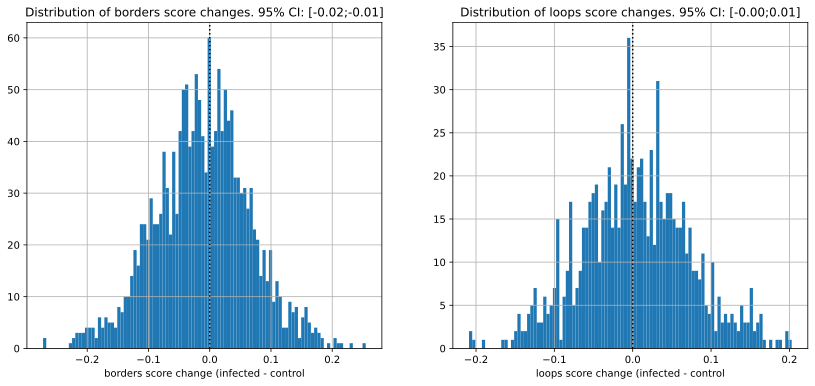

In [93]:

import scipy.stats as ss
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, (df, pat) in enumerate(zip([borders_change, loops_change], ['borders', 'loops'])):
    df.diff_score.hist(bins=100, ax=axes[i])
    axes[i].axvline(0, ls=':', c='black')
    ci_mean, _, _ = ss.bayes_mvs(df.diff_score, alpha=0.95)
    ci_low, ci_up = ci_mean[1]
    axes[i].set_title(f'Distribution of {pat} score changes. 95% CI: [{ci_low:.2f};{ci_up:.2f}]')
    axes[i].set_xlabel(f'{pat} score change (infected - control')
plt.suptitle("")

Text(0, 0.5, 'Score change (infected - control)')

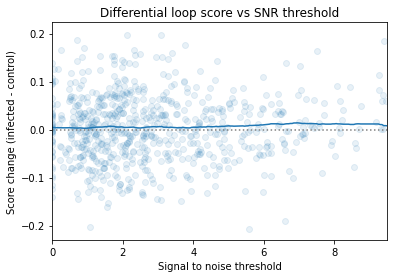

In [14]:

plt.scatter(
    loops_change.snr,
    loops_change.diff_score,
    alpha=0.1
)
plt.plot(
    np.arange(0, 10, 0.05),
    [np.mean(filter_patterns(loops_change, snr).diff_score) for snr in np.arange(0, 10, 0.05)]
)
plt.xlim((0, 9.5))
plt.axhline(0, c='grey', ls=':')
_ = plt.title('Differential loop score vs SNR threshold')
plt.xlabel('Signal to noise threshold')
plt.ylabel('Score change (infected - control)')

In [218]:
samples

,library,condition,infection_time,protocol,date
0,AT418,infected,5,hic_arima_dpnII,2020-05
1,AT419,uninfected,0,hic_arima_dpnII,2020-05
2,AT420,infected,5,hic_arima_dpnII,2020-05
3,AT421,uninfected,0,hic_arima_dpnII,2020-05


In [94]:
print(f"Keeping {diff_borders.shape[0]} borders and {diff_loops.shape[0]} loops with detectable change..")

Keeping 804 borders and 228 loops with detectable change..


In [72]:
def compute_di(mat, max_pix=10):
    """ Computes directionalitin index according to definition from Dixon et al., 2012"""
    
    di = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        before = np.nanmean(mat[i - max_pix: i, i -  max_pix: i])
        after = np.nanmean(mat[i: i + max_pix, i: i +  max_pix])
        expected = (before + after ) / 2
        sign = ((before - after) / np.abs(before - after))
        di[i] = sign * (((after - expected)**2) / expected + ((before - expected)**2) / expected)
    di[:max_pix] = 0
    di[-max_pix:] = 0
    high = np.nanmax(np.abs(di))
    di /= high # Scale to 1
    return di

In [73]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions
def plot_regions(healthy_cool, infected_cool, df, region_id, region_size=100000, blur=0):
    
    def region_lines(ax, s, e):
        """Add lines to mark region of differential contacts"""
        style = {"lw": 0.5, "alpha": 0.6, "c": "g"}
        for i in range(3):
            ax[0, i].axvline(x=s, **style)
            ax[0, i].axvline(x=e, **style)
            ax[0, i].axhline(y=s, **style)
            ax[0, i].axhline(y=e, **style)
            ax[1, i].axvline(x=s, **style)
            ax[1, i].axvline(x=e, **style)
            
    
    def nan_gaussian(U, sigma):
        """Gaussian filter which does not include NAs"""
        import scipy.ndimage as ndi
        V=U.copy()
        V[np.isnan(U)]=0
        VV=ndi.gaussian_filter(V, sigma=sigma)
        W=0*U.copy()+1
        W[np.isnan(U)]=0
        WW=ndi.gaussian_filter(W, sigma=sigma)
        Z=VV/WW   
        return Z
    
    # Extract region of interest
    region = df.iloc[region_id]
    chrom, start, end = region.chrom1, region.start1, region.end1
    pos = (start + end) / 2
    ucsc_query = f'{chrom}:{int(max(0, pos-region_size))}-{int(pos+region_size)}'
    
    # Subset matrix
    healthy_zoom = healthy_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom = infected_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom[np.isnan(infected_zoom)] = 0.0
    healthy_zoom[np.isnan(healthy_zoom)] = 0.0
    
    # Blur ratio to improve readability
    if blur > 0:
        infected_blur = nan_gaussian(infected_zoom, sigma=blur)
        healthy_blur = nan_gaussian(healthy_zoom, sigma=blur)
    else:
        infected_blur = infected_zoom
        healthy_blur = healthy_zoom

    log_ratio = np.log2(infected_blur / healthy_blur)
    #log_ratio[np.isnan(infected_zoom)] = 0.0
    #log_ratio[np.isnan(healthy_zoom)] = 0.0
    
    # Initialize figure
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, gridspec_kw={'height_ratios': [5, 1]})
    
    # Draw lines
    region_size = (end - start) // healthy_cool.binsize
    mid = healthy_zoom.shape[0] // 2
    start_bin, end_bin = mid - region_size, mid + region_size
    region_lines(ax, start_bin, end_bin)
    
    # Make heatmap
    plt.suptitle(f"{chrom}:{start}-{end}")
    ax[0, 0].imshow(np.log2(infected_zoom), cmap="Reds")
    ax[0, 0].set_title("Infected")
    ax[0, 1].imshow(np.log2(healthy_zoom), cmap="Reds")
    ax[0, 1].set_title("Uninfected")
    ax[0, 2].imshow(log_ratio, cmap='bwr', vmin=-2, vmax=2)
    ax[0, 2].set_title("I / U")
    
    # Plot DI
    n = infected_zoom.shape[0]
    infected_di = compute_di(infected_zoom, max_pix=10)
    healthy_di = compute_di(healthy_zoom, max_pix=10)
    
    for i in range(3): ax[1, i].set_ylim(-1, 1, emit=False)
    for i in range(3): ax[1, i].axhline(0, lw=0.5, c='black')
    ax[1, 0].plot(range(n), infected_di)
    ax[1, 1].plot(range(n), healthy_di)
    ax[1, 2].plot(range(n), infected_di - healthy_di)



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
region_size_slider = widgets.IntSlider(min=10000, max=500000, step=2000, value=100000)
blur_slider = widgets.FloatSlider(min=0, max=4, step=0.1, value=0)
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_borders),
                 region_id=range(diff_borders.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

In [18]:
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions


#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_loops),
                 region_id=range(diff_loops.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

All genes that overlap regions of differential contacts are then selected. This may not be optimal because genes may be separated from their enhancer element without being affected directly. This can happen if a domain boundary moves into the sequence between gene and enhancer.

The enrichment of GO terms (annotations) within regions with altered chromatin conformation is then tested to check for specific pathways or funcions.

In [74]:
genes.head()

,GeneID,TranscriptID,Feature,Chromosome,Start,End,Strand,Name,Product,Alias/Synonyms,...,GO Terms,Secreted,Membrane,Protease,CAZyme,Notes,gDNA,mRNA,CDS-transcript,Translation
0,VMHBD_00001,VMHBD_00001-T1,mRNA,scaffold_1,504,5457,-,NaN,hypothetical protein,NaN,...,GO_component: GO:0016020 - membrane [Evidence ...,NaN,NaN,NaN,NaN,NaN,ATGGCCACGAAAGATTTCAAGATCGCCAGTACGCGTGCCTCCTTTT...,TTACTTGGCAAGTGGGACAAAGAGAAATCCCTTTTGGCATTGTGCA...,TTACTTGGCAAGTGGGACAAAGAGAAATCCCTTTTGGCATTGTGCA...,MATKDFKIAIGGPGGVGKSAIVLQFVTGNYVSEYDPTIEDAYRKQF...
1,VMHBD_00002,VMHBD_00002-T1,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
2,VMHBD_00002,VMHBD_00002-T2,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
3,VMHBD_00002,VMHBD_00002-T3,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...
4,VMHBD_00002,VMHBD_00002-T4,mRNA,scaffold_1,5352,9953,+,NaN,hypothetical protein,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,GCATTCTTGAGGTTAGACCAAGCTTTGCCCAGCTTCACGTGACCTC...,ATGCTCGGCCGCGAGGAGGATGTCGACGACTCGAGCGCTACGTTGC...,MLGREEDVDDSSATLPPRLSPRLRSHRDEDEPPRVDALELMTPSPR...


In [110]:
import pyranges as pr
genes_pr = pr.PyRanges(genes)

In [111]:
diff_borders_pr = pr.PyRanges(
    diff_borders
    .loc[:, ["chrom1", "start1", "end1", "diff_score"]]
    .rename(columns={"chrom1": "Chromosome", "start1": "Start", "end1": "End", "diff_score": "Diff_score"})
)
diff_loops_pr = pr.PyRanges(
    pd.concat([
        (diff_loops
            .loc[:, ["chrom1", "start1", "end1", "diff_score"]]
            .rename(columns={"chrom1": "Chromosome", "start1": "Start", "end1": "End", "diff_score": "Diff_score"})),
        (diff_loops
        .loc[:, ["chrom2", "start2", "end2", "diff_score"]]
        .rename(columns={"chrom2": "Chromosome", "start2": "Start", "end2": "End", "diff_score": "Diff_score"}))
    ])
)

In [112]:
# Overlap with annotations (genes within 5kb assigned to pattern)
diff_borders_genes = genes_pr.join(diff_borders_pr, slack=5000).df
diff_loops_genes = genes_pr.join(diff_loops_pr, slack=5000).df

Extract known proteins, excluding tRNA genes for visual inspection

In [113]:
def gene_stats(df, name):
    is_known = df.Product != 'hypothetical protein'
    known = len(is_known[is_known])
    is_trna = df.Product.str.contains('tRNA-')
    trna = len(is_trna[is_trna])
    print(
        f"There are {df.shape[0]} {name}, of which {known} have known functions, "
        f"including {trna} tRNAs."
    )

In [114]:
known_loops_genes = diff_loops_genes.loc[(~diff_loops_genes.Product.str.contains('tRNA-')) & (diff_loops_genes.Product != 'hypothetical protein'), :]

In [115]:
known_borders_genes = diff_borders_genes.loc[(~diff_borders_genes.Product.str.contains('tRNA-')) & (diff_borders_genes.Product != 'hypothetical protein'), :]

In [116]:

gene_stats(genes, "genes in the genome")


There are 16890 genes in the genome, of which 440 have known functions, including 3 tRNAs.


In [126]:
gene_stats(diff_loops_genes, 'infection dependent loop genes')

There are 2394 infection dependent loop genes, of which 54 have known functions, including 0 tRNAs.


In [125]:
gene_stats(diff_borders_genes, 'infection dependent border genes')

There are 4546 infection dependent border genes, of which 115 have known functions, including 1 tRNAs.


In [124]:
print(
    (known_borders_genes
        .loc[:, ["GeneID", "Chromosome", "Start", "End", "Strand", "Name", "Product","Diff_score"]]
        .sort_values('Diff_score')
        .to_markdown())
)

|      | GeneID      | Chromosome   |   Start |     End | Strand   | Name      | Product                                                                                      |   Diff_score |
|-----:|:------------|:-------------|--------:|--------:|:---------|:----------|:---------------------------------------------------------------------------------------------|-------------:|
| 4270 | VMHBD_11950 | scaffold_31  |  634202 |  634648 | +        | AP2S1_2   | AP-2 complex subunit sigma                                                                   |   -0.202505  |
|  769 | VMHBD_13077 | scaffold_4   |  816324 |  817295 | +        | RPS23_1   | 40S ribosomal protein S23, variant 3                                                         |   -0.17602   |
|  526 | VMHBD_06778 | scaffold_2   | 2100731 | 2102460 | -        | WDR68_1   | DDB1- and CUL4-associated factor 7                                                           |   -0.172481  |
| 3723 | VMHBD_09140 | scaffold_25  |  525091

In [127]:
print(
    (known_loops_genes
        .loc[:, ["GeneID", "Chromosome", "Start", "End", "Strand", "Name", "Product","Diff_score"]]
        .groupby('Name')
        .head(1)
        .sort_values('Diff_score')
        .to_markdown())
)


|      | GeneID      | Chromosome   |   Start |     End | Strand   | Name      | Product                                                        |   Diff_score |
|-----:|:------------|:-------------|--------:|--------:|:---------|:----------|:---------------------------------------------------------------|-------------:|
|   88 | VMHBD_00821 | scaffold_1   | 2082496 | 2083394 | +        | NDUFS7    | NADH dehydrogenase Fe-S protein subunit 7 ndufs7               |   -0.20729   |
|  172 | VMHBD_00822 | scaffold_1   | 2083307 | 2084941 | -        | RFC2      | Subunit of heteropentameric Replication factor C (RF-C)        |   -0.20729   |
| 1519 | VMHBD_05134 | scaffold_18  |  120150 |  122167 | +        | PHO2B_1   | Protein phosphatase 2A catalytic subunit B                     |   -0.126019  |
| 1554 | VMHBD_05140 | scaffold_18  |  140681 |  143190 | -        | DPH1      | Diphthamide biosynthesis protein 1                             |   -0.126019  |
|  364 | VMHBD_11145 | scaffold_3 